# Importing Required Libraries

In [1]:
from sklearn.datasets import fetch_openml

from sklearn.svm import SVC

from sklearn.model_selection import train_test_split
from sklearn.metrics import make_scorer, f1_score, accuracy_score
from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import GridSearchCV

from sklearn.pipeline import Pipeline

import numpy as np

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns

import pandas as pd

import os

# Fetching dataset and save it on local machine

In [2]:
def fetch_save_dataset(data_id:int, dataset_name:str):
    # Fetch the dataset with data_id
    dataset = fetch_openml(data_id=data_id, as_frame=True)  
    
    # Separate data and target
    data = dataset.data
    target = dataset.target
    
    # Combine Data and Target: Add the target column to the DataFrame:
    combined = pd.concat([data, target.rename("Target")], axis=1)
    
    # Save to CSV: Write the combined DataFrame to a CSV file:
    
    combined.to_csv(dataset_name, index=False)

    return True if dataset else False

# 0. Loading Dataset


In [3]:
dataset_name = 'blood_transfusion.csv'
dataset_id = 1464
data_path = f"./{dataset_name}.csv"
if not os.path.isfile(data_path):
    fetch_save_dataset(dataset_id, dataset_name)

X = pd.read_csv(dataset_name).set_axis(labels=list(range(5)), axis= 1)

Y = np.array(X.pop(4))
X = np.array(X)
print(X.shape, Y.shape)

(748, 4) (748,)


# 1. Preprocessing Dataset

In [7]:

min_max_scaler = MinMaxScaler()
X = min_max_scaler.fit_transform(X)

# 2. Splitting Dataset

In [8]:
x_train, \
x_temp, \
y_train, \
y_temp = train_test_split(X,
                          Y, 
                          test_size = .3, 
                          random_state=42)
x_test,\
x_val,\
y_test,\
y_val = train_test_split(x_temp, 
                         y_temp,
                         test_size=.5,
                         random_state=42)

print(x_train.shape, x_test.shape, x_val.shape)


(523, 4) (112, 4) (113, 4)


In [23]:
# simple model training

svc_poly = SVC(kernel="poly",C=.1, degree=1)
svc_poly.fit(x_train, y_train)

SVC(C=0.1, degree=1, kernel='poly')

In [24]:
y_pre_val = svc_poly.predict(x_val)
accuracy_score(y_true=y_val, y_pred=y_pre_val)

0.6814159292035398

# 3. Create a pipeline to scale data and train SVM

In [27]:
pipeline = Pipeline([
    ('scaler', MinMaxScaler()),
    ('svm', SVC())
])


# 4. Preparing a Grid Search for Hyper Parameter Tunning

In [63]:
cached_param_grid_rbf  = {
    'svm__C': [.1, .4, .7, 1, 3, 17, 37, 103, 707, 1507],
    'svm__gamma': [.1, .4, .7, 1, 3, 17, 37, 103, 707, 1507],
    'svm__kernel': ['rbf']
}
C_search_space=np.round(np.linspace(0.1, 10, 20),2)
gamma_search_space=np.round(np.linspace(1, 20, 20),2)
print(C_search_space)
param_grid_rbf = {
    'svm__C': C_search_space,
    'svm__gamma': gamma_search_space,
    'svm__kernel': ['rbf']
}

scoring = {
    'f1_score': make_scorer(f1_score, average='weighted'), 
    'accuracy': 'accuracy'
}


grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid_rbf,
    cv=5,                         # Use 5-fold cross-validation
    scoring=scoring,              # Use multiple metrics
    refit='f1_score',             # Optimize the model for F1-score
    n_jobs=-1                     # Use all available CPU cores
)



[ 0.1   0.62  1.14  1.66  2.18  2.71  3.23  3.75  4.27  4.79  5.31  5.83
  6.35  6.87  7.39  7.92  8.44  8.96  9.48 10.  ]


# 5. Fit the Model on the Training Set (this includes cross-validation)


In [64]:
grid_search.fit(x_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', MinMaxScaler()),
                                       ('svm', SVC())]),
             n_jobs=-1,
             param_grid={'svm__C': array([ 0.1 ,  0.62,  1.14,  1.66,  2.18,  2.71,  3.23,  3.75,  4.27,
        4.79,  5.31,  5.83,  6.35,  6.87,  7.39,  7.92,  8.44,  8.96,
        9.48, 10.  ]),
                         'svm__gamma': array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
       14., 15., 16., 17., 18., 19., 20.]),
                         'svm__kernel': ['rbf']},
             refit='f1_score',
             scoring={'accuracy': 'accuracy',
                      'f1_score': make_scorer(f1_score, response_method='predict', average=weighted)})

# 6. Saving the Result of Grid Search

In [65]:
results = grid_search.cv_results_

df = pd.DataFrame(grid_search.cv_results_)

mean_test_accuracy = df[['params', 'mean_test_accuracy']].copy()


# Save to CSV
df.to_csv("grid_search_results.csv", index=False)

print("Results saved to grid_search_results.csv")

mean_test_accuracy_sorted = mean_test_accuracy.sort_values(by="mean_test_accuracy",  ascending=False)
params = df.columns[4:8]
params

Results saved to grid_search_results.csv


Index(['param_svm__C', 'param_svm__gamma', 'param_svm__kernel', 'params'], dtype='object')

# 7. Plotting the Hyper Parameters with respect to the accuracy 

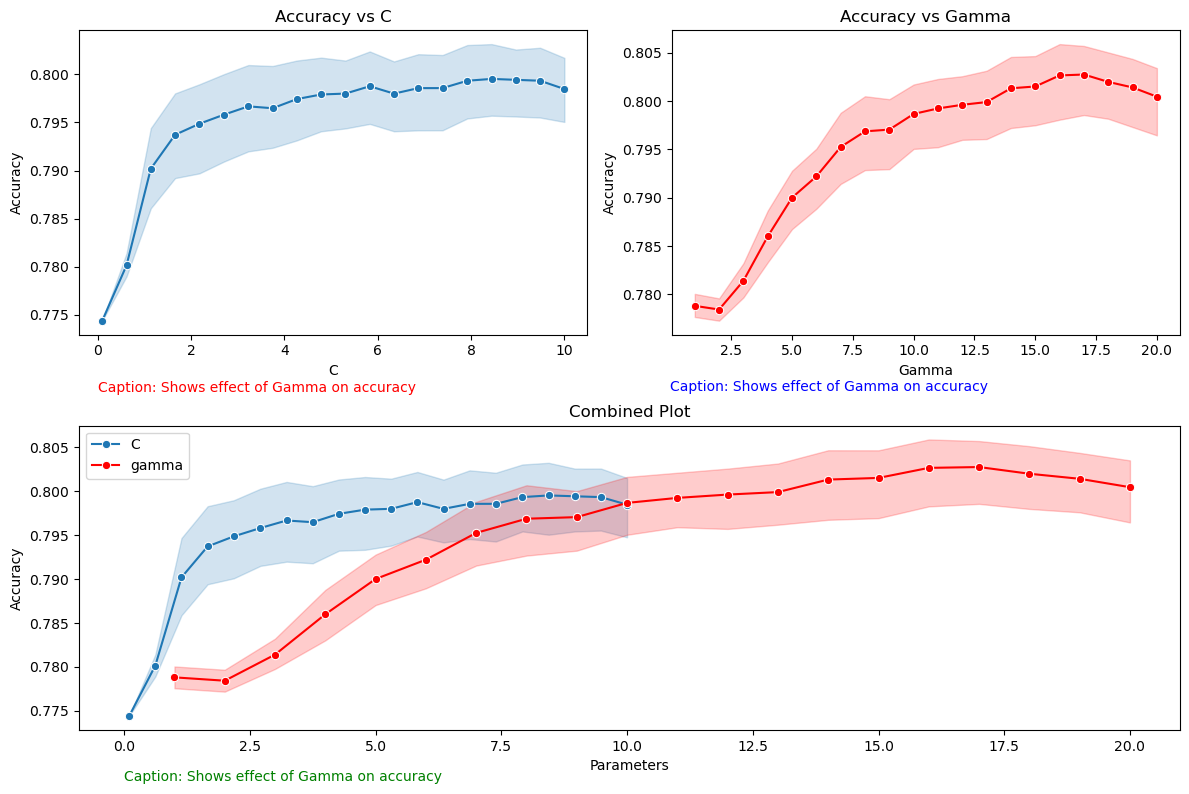

In [83]:
# Set up the figure and GridSpec
fig = plt.figure(figsize=(12, 8))
gs = GridSpec(2, 2, figure=fig)  # Define a 2x2 grid layout

# First plot (Row 1, Column 1)
ax1 = fig.add_subplot(gs[0, 0])
sns.lineplot(ax=ax1, x='param_svm__C', y='mean_test_accuracy', data=df, marker='o')
ax1.set_title("Accuracy vs C")
ax1.set_xlabel("C")
ax1.set_ylabel("Accuracy")
ax1.text(0, 0.767, "Caption: Shows effect of Gamma on accuracy", fontsize=10, color="red")


# Second plot (Row 1, Column 2)
ax2 = fig.add_subplot(gs[0, 1])
sns.lineplot(ax=ax2, x='param_svm__gamma', y='mean_test_accuracy', data=df, marker='o', color='r')
ax2.set_title("Accuracy vs Gamma")
ax2.set_xlabel("Gamma")
ax2.set_ylabel("Accuracy")
ax2.text(0, 0.77, "Caption: Shows effect of Gamma on accuracy", fontsize=10, color="blue")

# Third plot spanning the entire second row (Row 2, Columns 0 & 1)
ax3 = fig.add_subplot(gs[1, :])  # Span across all columns in the second row
sns.lineplot(ax=ax3, x='param_svm__C', y='mean_test_accuracy', data=df, marker='o', label='C')
sns.lineplot(ax=ax3, x='param_svm__gamma', y='mean_test_accuracy', data=df, marker='o', color='r', label='gamma')
# sns.lineplot(ax=ax3, x='param_svm__coef0', y='mean_test_accuracy', data=df, marker='o', color='g', label='coef0')
ax3.set_title("Combined Plot")
ax3.set_xlabel("Parameters")
ax3.set_ylabel("Accuracy")
ax3.text(0, 0.767, "Caption: Shows effect of Gamma on accuracy", fontsize=10, color="green")
ax3.legend()

# Adjust layout
plt.tight_layout()
plt.show()


# Step 8: Validate the model


In [67]:
# Step 8: Validate the model
y_val_pred = grid_search.predict(x_val)
val_accuracy = accuracy_score(y_val, y_val_pred)
val_f1 = f1_score(y_val, y_val_pred, average='weighted')

print("Validation Accuracy:", val_accuracy)
print("Validation F1-Score:", val_f1)


Validation Accuracy: 0.7522123893805309
Validation F1-Score: 0.7069702694640548


# 9. Final evaluation on the test set


In [68]:
y_test_pred = grid_search.predict(x_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred, average='weighted')

print("Test Accuracy:", test_accuracy)
print("Test F1-Score:", test_f1)

Test Accuracy: 0.7857142857142857
Test F1-Score: 0.7410714285714286


# Step 10: Best Parameters and Results from Grid Search


In [69]:
# Step 12: Best Parameters and Results from Grid Search
print("Best Parameters from Grid Search:", grid_search.best_params_)
print("Best score from Grid Search:", grid_search.best_score_)
print("Best estimator from Grid Search:",  grid_search.best_estimator_)

Best Parameters from Grid Search: {'svm__C': 8.96, 'svm__gamma': 16.0, 'svm__kernel': 'rbf'}
Best score from Grid Search: 0.780190355998717
Best estimator from Grid Search: Pipeline(steps=[('scaler', MinMaxScaler()), ('svm', SVC(C=8.96, gamma=16.0))])


# 11. Repeating steps 4-10 the Process Again to Achieve Maximum Performance